<a href="https://colab.research.google.com/github/sayanbanerjee32/TSAI_ERAv2_S8/blob/main/S8_BN_SayanBanerjee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import all required packages including local files

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary

import matplotlib.pyplot as plt

#import from local modules
from utils import train, test, get_device, plot_accuracy_losses, plot_top_loss

# Check if GPU available

In [2]:
# CUDA? - call get_device function defined in utils.py
is_cuda, device = get_device()

CUDA Available? True


# Visualising Train data

# Dataset and Creating Train/Test Split

In [3]:
train_data_raw = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())

Files already downloaded and verified


In [4]:
print(train_data_raw.data.shape)
print(train_data_raw.data.mean(axis=(0,1,2))/255)
print(train_data_raw.data.std(axis=(0,1,2))/255)

(50000, 32, 32, 3)
[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


# Dataloader Arguments & Test/Train Dataloaders

In [5]:
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if is_cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader_raw = torch.utils.data.DataLoader(train_data_raw, **dataloader_args)

class_labels = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Data Visualization

torch.Size([128, 3, 32, 32])
torch.Size([128])


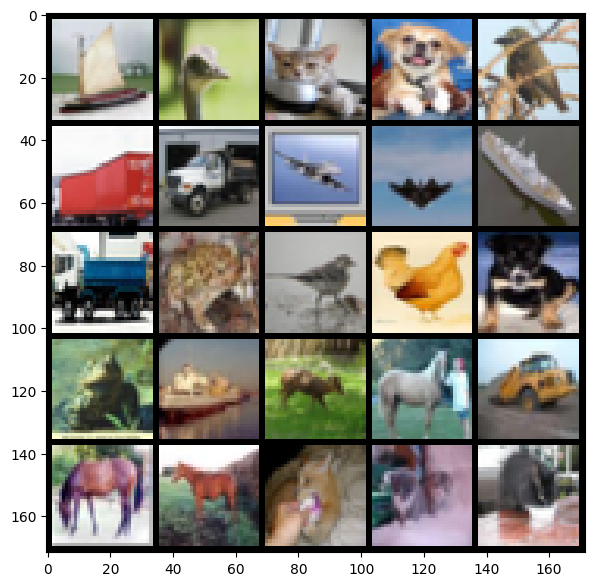

In [6]:
dataiter = iter(train_loader_raw)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Create a grid of images
grid = torchvision.utils.make_grid(images[:25], nrow=5)

# Display the grid
plt.figure(figsize=(7,7))
plt.imshow(grid.permute(1,2,0))
plt.show()

In [7]:
# how labels look like
print(' '.join(f'{class_labels[labels[j]]:5s}' for j in range(len(labels[:25]))))

ship  bird  cat   dog   bird  truck truck plane plane ship  truck frog  bird  bird  dog   frog  ship  deer  horse truck horse horse dog   cat   cat  


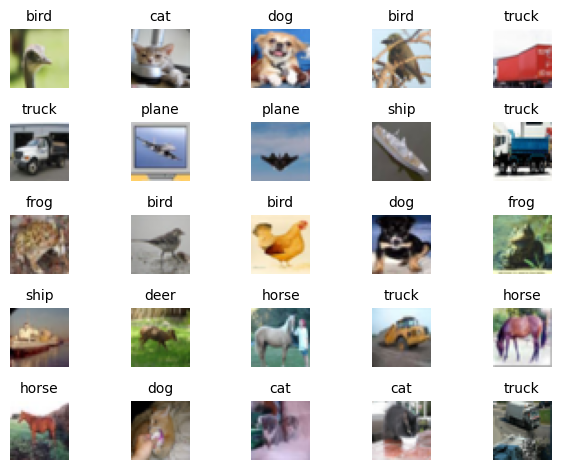

In [8]:
figure = plt.figure()
rows, cols = 5, 5
for index in range(1, cols * rows  + 1):
    plt.subplot(rows, cols, index)
    plt.title(class_labels[labels[index]],fontsize = 10)
    plt.axis('off')
    plt.imshow(images[index].permute(1, 2, 0))
figure.tight_layout()
plt.show()

# Train and Test transformations

In [9]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                        # transforms.RandomApply([transforms.CenterCrop(22),], p=0.1),
                                        # transforms.Resize((28, 28)), # 99.08, 99.38
                                        # transforms.RandomApply([transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),], p=0.1), # 99.89, 99.36
                                        # transforms.RandomApply([transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=15),], p=0.1), # 98.60, 99.35
                                        transforms.RandomApply([transforms.RandomResizedCrop(size=(32, 32))], p=0.1),
                                        transforms.RandomRotation((-15.0, 15.0), fill=(1,)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.49139968,0.48215841,0.44653091), (0.24703223,0.24348513,0.26158784)),
                                        # transforms.RandomErasing(p=0.1), #97.88, 99.32
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.49139968,0.48215841,0.44653091), (0.24703223,0.24348513,0.26158784))
                                       ])

# Dataset and Creating Train/Test Split

In [10]:
train_data = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders

In [11]:
# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

## Data Visualization

# Training

In [12]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, n = 8, dropout_value = 0.1):
        super(Net, self).__init__()
        # # Input Block
        self.C1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=n,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(n),
            nn.Dropout(dropout_value)
        ) #input size: 28 x 28 x 1, output size: 26 x 26 x n, receptive field: 1 + (3-1) * 1 = 3

        # CONVOLUTION BLOCK 1
        self.C2 = nn.Sequential(
            nn.Conv2d(in_channels=n, out_channels=n*2,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(n*2),
            nn.Dropout(dropout_value)
        ) #input size: 26 x 26 x n, output size: 24 x 24 x n*2, receptive field: 3 + (3-1) * 1 = 5

        # TRANSITION BLOCK 1
        self.c3 = nn.Sequential(
            nn.Conv2d(in_channels=n*2, out_channels=n,
                      kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(n),
            nn.Dropout(dropout_value)
        ) #input size: 12 x 12 x n*2, output size: 12 x 12 x n, receptive field: 6 + (1-1)*2 = 6
        self.p1 = nn.MaxPool2d(2, 2) #input size: 24 x 24 x n*2, output size: 12 x 12 x n*2, receptive field: 5 + (2-1) * 1 = 6

        # CONVOLUTION BLOCK 2
        self.C4 = nn.Sequential(
            nn.Conv2d(in_channels=n, out_channels=n*2,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(n*2),
            nn.Dropout(dropout_value)
        ) #input size: 12 x 12 x n, output size: 10 x 10 x n*2, receptive field: 6 + (3-1) * 2 = 10

        self.C5 = nn.Sequential(
            nn.Conv2d(in_channels=n*2, out_channels=n*2,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(n*2),
            nn.Dropout(dropout_value)
        ) #input size: 10 x 10 x n*2, output size: 8 x 8 x n*2, receptive field: 10 + (3-1) * 2 = 14

        self.C6 = nn.Sequential(
            nn.Conv2d(in_channels=n*2, out_channels=n*2,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(n*2),
            nn.Dropout(dropout_value)
        ) #input size: 8 x 8 x n*2, output size: 6 x 6 x n*2, receptive field: 14 + (3-1) * 2 = 18

        # TRANSITION BLOCK 2
        self.c7 = nn.Sequential(
            nn.Conv2d(in_channels=n*2, out_channels=n,
                      kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(n),
            nn.Dropout(dropout_value)
        ) #input size: 12 x 12 x n*2, output size: 12 x 12 x n, receptive field: 6 + (1-1)*2 = 6
        self.p2 = nn.MaxPool2d(2, 2) #input size: 24 x 24 x n*2, output size: 12 x 12 x n*2, receptive field: 5 + (2-1) * 1 = 6


        # CONVOLUTION BLOCK 3
        self.C8 = nn.Sequential(
            nn.Conv2d(in_channels=n, out_channels=n*2,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(n*2),
            nn.Dropout(dropout_value)
        ) #input size: 12 x 12 x n, output size: 10 x 10 x n*2, receptive field: 6 + (3-1) * 2 = 10

        self.C9 = nn.Sequential(
            nn.Conv2d(in_channels=n*2, out_channels=n*2,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(n*2),
            nn.Dropout(dropout_value)
        ) #input size: 10 x 10 x n*2, output size: 8 x 8 x n*2, receptive field: 10 + (3-1) * 2 = 14

        self.C10 = nn.Sequential(
            nn.Conv2d(in_channels=n*2, out_channels=n*2,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(n*2),
            nn.Dropout(dropout_value)
        ) #input size: 8 x 8 x n*2, output size: 6 x 6 x n*2, receptive field: 14 + (3-1) * 2 = 18

        # OUTPUT BLOCK
        self.GAP = nn.Sequential(
            # nn.AvgPool2d(kernel_size=7) # 7>> 9...
            nn.AdaptiveAvgPool2d((1, 1))
        ) #input size: 6 x 6 x n*2, output size: 1 x 1 x n*2, receptive field: 18

        self.c11 = nn.Sequential(
            nn.Conv2d(in_channels=n*2, out_channels=10,
                      kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU()
        ) #input size: 1 x 1 x n*2, output size: 1 x 1 x 10, receptive field: 18 + (1-1) * 2 =18



    def forward(self, x):
        x = self.C1(x)
        x = self.C2(x)

        x = self.c3(x)
        x = self.p1(x)

        x = self.C4(x)
        x = self.C5(x)
        x = self.C6(x)

        x = self.c7(x)
        x = self.p2(x)

        x = self.C8(x)
        x = self.C9(x)
        x = self.C10(x)

        x = self.GAP(x)
        x = self.c11(x)

        x = x.squeeze()

        return F.log_softmax(x, dim=-1)


In [21]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, n = 8, dropout_value = 0.1):
        super(Net, self).__init__()
        # # Input Block
        self.C1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=n*2,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(n*2),
            nn.Dropout(dropout_value)
        ) #input size: 28 x 28 x 1, output size: 26 x 26 x n, receptive field: 1 + (3-1) * 1 = 3

        # CONVOLUTION BLOCK 1
        self.C2 = nn.Sequential(
            nn.Conv2d(in_channels=n*2, out_channels=n*4,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(n*4),
            nn.Dropout(dropout_value)
        ) #input size: 26 x 26 x n, output size: 24 x 24 x n*2, receptive field: 3 + (3-1) * 1 = 5

        # TRANSITION BLOCK 1
        self.c3 = nn.Sequential(
            nn.Conv2d(in_channels=n*4, out_channels=n,
                      kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(n),
            nn.Dropout(dropout_value)
        ) #input size: 12 x 12 x n*2, output size: 12 x 12 x n, receptive field: 6 + (1-1)*2 = 6
        self.p1 = nn.MaxPool2d(2, 2) #input size: 24 x 24 x n*2, output size: 12 x 12 x n*2, receptive field: 5 + (2-1) * 1 = 6

        # CONVOLUTION BLOCK 2
        self.C4 = nn.Sequential(
            nn.Conv2d(in_channels=n, out_channels=n*2,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(n*2),
            nn.Dropout(dropout_value)
        ) #input size: 12 x 12 x n, output size: 10 x 10 x n*2, receptive field: 6 + (3-1) * 2 = 10

        self.C5 = nn.Sequential(
            nn.Conv2d(in_channels=n*2, out_channels=n*4,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(n*4),
            nn.Dropout(dropout_value)
        ) #input size: 10 x 10 x n*2, output size: 8 x 8 x n*2, receptive field: 10 + (3-1) * 2 = 14

        self.C6 = nn.Sequential(
            nn.Conv2d(in_channels=n*4, out_channels=n*4,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(n*4),
            nn.Dropout(dropout_value)
        ) #input size: 8 x 8 x n*2, output size: 6 x 6 x n*2, receptive field: 14 + (3-1) * 2 = 18

        # TRANSITION BLOCK 2
        self.c7 = nn.Sequential(
            nn.Conv2d(in_channels=n*4, out_channels=n,
                      kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(n),
            nn.Dropout(dropout_value)
        ) #input size: 12 x 12 x n*2, output size: 12 x 12 x n, receptive field: 6 + (1-1)*2 = 6
        self.p2 = nn.MaxPool2d(2, 2) #input size: 24 x 24 x n*2, output size: 12 x 12 x n*2, receptive field: 5 + (2-1) * 1 = 6


        # CONVOLUTION BLOCK 3
        self.C8 = nn.Sequential(
            nn.Conv2d(in_channels=n, out_channels=n*2,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(n*2),
            nn.Dropout(dropout_value)
        ) #input size: 12 x 12 x n, output size: 10 x 10 x n*2, receptive field: 6 + (3-1) * 2 = 10

        self.C9 = nn.Sequential(
            nn.Conv2d(in_channels=n*2, out_channels=n*4,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(n*4),
            nn.Dropout(dropout_value)
        ) #input size: 10 x 10 x n*2, output size: 8 x 8 x n*2, receptive field: 10 + (3-1) * 2 = 14

        self.C10 = nn.Sequential(
            nn.Conv2d(in_channels=n*4, out_channels=n*4,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(n*4),
            nn.Dropout(dropout_value)
        ) #input size: 8 x 8 x n*2, output size: 6 x 6 x n*2, receptive field: 14 + (3-1) * 2 = 18

        # OUTPUT BLOCK
        self.GAP = nn.Sequential(
            # nn.AvgPool2d(kernel_size=7) # 7>> 9...
            nn.AdaptiveAvgPool2d((1, 1))
        ) #input size: 6 x 6 x n*2, output size: 1 x 1 x n*2, receptive field: 18

        self.c11 = nn.Sequential(
            nn.Conv2d(in_channels=n*4, out_channels=10,
                      kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU()
        ) #input size: 1 x 1 x n*2, output size: 1 x 1 x 10, receptive field: 18 + (1-1) * 2 =18



    def forward(self, x):
        x = self.C1(x)
        x = self.C2(x)

        x = self.c3(x)
        x = self.p1(x)

        x = self.C4(x)
        x = self.C5(x)
        x = self.C6(x)

        x = self.c7(x)
        x = self.p2(x)

        x = self.C8(x)
        x = self.C9(x)
        x = self.C10(x)

        x = self.GAP(x)
        x = self.c11(x)

        x = x.squeeze()

        return F.log_softmax(x, dim=-1)


In [22]:
# visualise model parameters
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9            [-1, 8, 32, 32]             256
             ReLU-10            [-1, 8, 32, 32]               0
      BatchNorm2d-11            [-1, 8, 32, 32]              16
          Dropout-12            [-1, 8, 32, 32]               0
        MaxPool2d-13            [-1, 8, 16, 16]               0
           Conv2d-14           [-1, 16,

In [23]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [24]:
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9) # reduce learning rate, loss not converging
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer  = optimizer,
                                                 mode = 'min',
                                                 factor = 0.1,
                                                 min_lr = 0.0001,
                                                 threshold_mode  = 'rel',
                                                 threshold = 0.0001,
                                                 patience  = 2,
                                                 verbose = True)
criterion = F.nll_loss
num_epochs = 20

for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    # call train function from utils.py
    trn_acc, trn_loss = train(model, device, train_loader, optimizer, criterion)
    # accumulate train accuracies and test losses for visualisation
    train_acc.append(trn_acc)
    train_losses.append(trn_loss)

    # call test function from utils.py
    tst_acc, tst_loss = test(model, device, test_loader, criterion)
    # accumulate test accuracies and test losses for visualisation
    test_acc.append(tst_acc)
    test_losses.append(tst_loss)

    scheduler.step(tst_loss)
    # print(f"learning rate={optimizer.state_dict()['param_groups'][0]['lr']}, trn_loss = {trn_loss}")



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1


  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Train: Loss=1.4326 Batch_id=390 Accuracy=37.09: 100%|██████████| 391/391 [00:25<00:00, 15.37it/s]


Test set: Average loss: 1.4423, Accuracy: 4669/10000 (46.69%)

Epoch 2


Train: Loss=1.3852 Batch_id=390 Accuracy=47.82: 100%|██████████| 391/391 [00:25<00:00, 15.27it/s]


Test set: Average loss: 1.2450, Accuracy: 5474/10000 (54.74%)

Epoch 3


Train: Loss=1.2685 Batch_id=390 Accuracy=52.76: 100%|██████████| 391/391 [00:24<00:00, 15.84it/s]


Test set: Average loss: 1.2131, Accuracy: 5609/10000 (56.09%)

Epoch 4


Train: Loss=1.2847 Batch_id=390 Accuracy=56.34: 100%|██████████| 391/391 [00:24<00:00, 16.21it/s]


Test set: Average loss: 1.1022, Accuracy: 6020/10000 (60.20%)

Epoch 5


Train: Loss=1.1306 Batch_id=390 Accuracy=57.96: 100%|██████████| 391/391 [00:23<00:00, 16.32it/s]


Test set: Average loss: 1.1209, Accuracy: 6017/10000 (60.17%)

Epoch 6


Train: Loss=1.1687 Batch_id=390 Accuracy=59.76: 100%|██████████| 391/391 [00:23<00:00, 16.49it/s]


Test set: Average loss: 1.0735, Accuracy: 6216/10000 (62.16%)

Epoch 7


Train: Loss=0.9689 Batch_id=390 Accuracy=60.80: 100%|██████████| 391/391 [00:24<00:00, 16.25it/s]


Test set: Average loss: 0.9661, Accuracy: 6596/10000 (65.96%)

Epoch 8


Train: Loss=1.1390 Batch_id=390 Accuracy=61.83: 100%|██████████| 391/391 [00:24<00:00, 15.93it/s]


Test set: Average loss: 1.0200, Accuracy: 6409/10000 (64.09%)

Epoch 9


Train: Loss=1.2002 Batch_id=390 Accuracy=62.95: 100%|██████████| 391/391 [00:24<00:00, 15.99it/s]


Test set: Average loss: 0.9478, Accuracy: 6627/10000 (66.27%)

Epoch 10


Train: Loss=1.2754 Batch_id=390 Accuracy=63.31: 100%|██████████| 391/391 [00:24<00:00, 15.76it/s]


Test set: Average loss: 0.9576, Accuracy: 6601/10000 (66.01%)

Epoch 11


Train: Loss=1.0770 Batch_id=390 Accuracy=64.32: 100%|██████████| 391/391 [00:25<00:00, 15.58it/s]


Test set: Average loss: 0.9175, Accuracy: 6787/10000 (67.87%)

Epoch 12


Train: Loss=1.0047 Batch_id=390 Accuracy=65.02: 100%|██████████| 391/391 [00:24<00:00, 15.84it/s]


Test set: Average loss: 0.8915, Accuracy: 6863/10000 (68.63%)

Epoch 13


Train: Loss=1.0051 Batch_id=390 Accuracy=65.47: 100%|██████████| 391/391 [00:25<00:00, 15.28it/s]


Test set: Average loss: 0.9792, Accuracy: 6496/10000 (64.96%)

Epoch 14


Train: Loss=0.8840 Batch_id=390 Accuracy=66.11: 100%|██████████| 391/391 [00:26<00:00, 14.97it/s]


Test set: Average loss: 0.8523, Accuracy: 6981/10000 (69.81%)

Epoch 15


Train: Loss=0.8378 Batch_id=390 Accuracy=66.26: 100%|██████████| 391/391 [00:24<00:00, 15.87it/s]


Test set: Average loss: 0.8285, Accuracy: 7081/10000 (70.81%)

Epoch 16


Train: Loss=0.9748 Batch_id=390 Accuracy=66.84: 100%|██████████| 391/391 [00:24<00:00, 16.11it/s]


Test set: Average loss: 0.8183, Accuracy: 7150/10000 (71.50%)

Epoch 17


Train: Loss=0.9756 Batch_id=390 Accuracy=67.03: 100%|██████████| 391/391 [00:25<00:00, 15.45it/s]


Test set: Average loss: 0.8543, Accuracy: 6971/10000 (69.71%)

Epoch 18


Train: Loss=0.7615 Batch_id=390 Accuracy=67.41: 100%|██████████| 391/391 [00:24<00:00, 15.69it/s]


Test set: Average loss: 0.8959, Accuracy: 6842/10000 (68.42%)

Epoch 19


Train: Loss=0.8925 Batch_id=390 Accuracy=68.01: 100%|██████████| 391/391 [00:24<00:00, 15.79it/s]


Test set: Average loss: 0.8165, Accuracy: 7132/10000 (71.32%)

Epoch 20


Train: Loss=0.8142 Batch_id=390 Accuracy=68.21: 100%|██████████| 391/391 [00:25<00:00, 15.45it/s]


Test set: Average loss: 0.8327, Accuracy: 7046/10000 (70.46%)



In [25]:
# final learning rate
scheduler.get_last_lr()

[0.1]

## Visualise training and test losses and accuracies

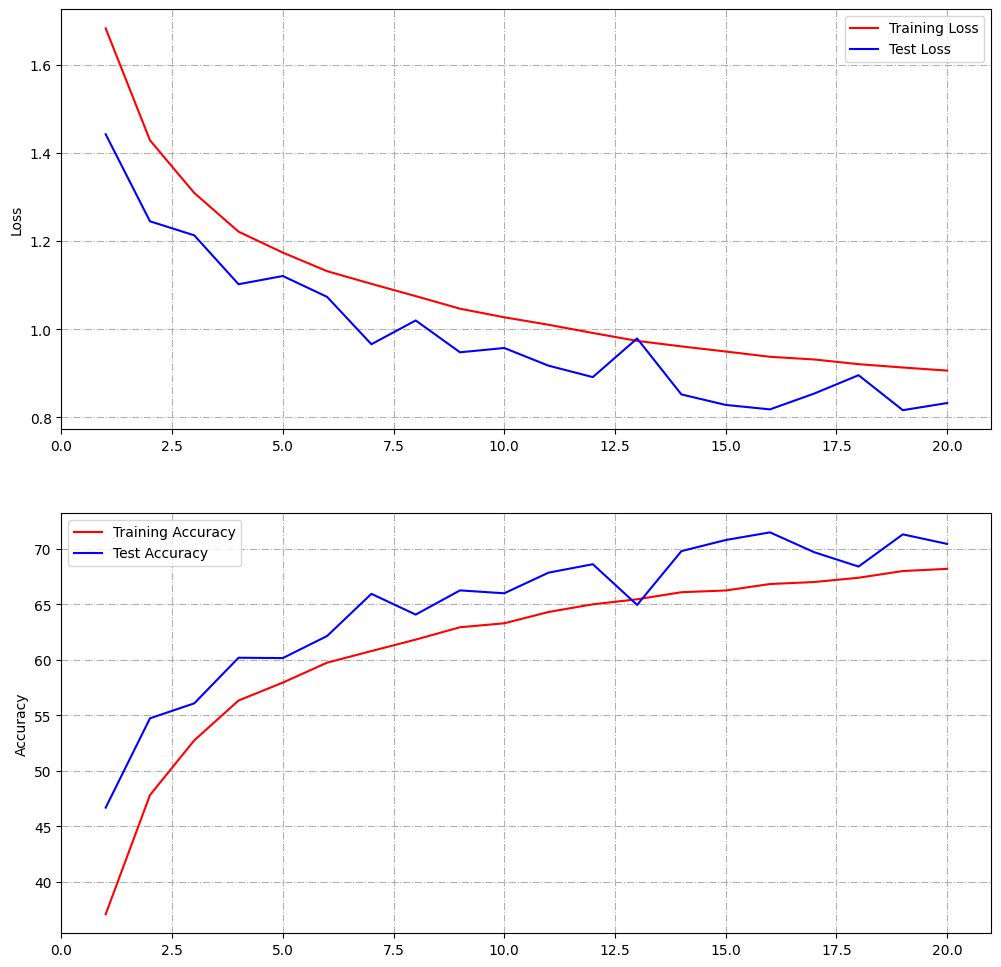

In [26]:
## use function from utils.py
plot_accuracy_losses(train_losses, train_acc, test_losses, test_acc, num_epochs)

## Error analysis

In [27]:
import pandas as  pd
from torchvision import transforms
# get predicted value based on argmax
def GetPrediction(pPrediction):
  return pPrediction.argmax(dim=1)


# Returns individual image with target, prediction and loss
# after batch inference
def get_individual_loss(model, device, data_loader, criterion):
    # switching on eval / test mode
    model.eval()

    loss_list = []


    # no gradient calculation is required for test
    ## as parameters are not updated while test
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)

            for d,t,p,l in zip(data, target,
                               GetPrediction(output),
                               criterion(output, target, reduction='none')):
                loss_list.append((d.to('cpu'),
                                  t.to('cpu').item(),
                                  p.to('cpu').item(),
                                  l.to('cpu').item()))


    return loss_list
# the following function will plot images with target and predicted values
# where prediction is wrong - this will be in order or decreasing loss
# group by target
def plot_top_loss(model, device, data_loader, criterion,
                  label_names = None, img_rows = 5, img_cols = 5,
                  de_normalize = True,
                  mean = [0.49139968,0.48215841,0.44653091],
                  std = [0.24703223,0.24348513,0.26158784]):
    loss_list = get_individual_loss(model, device, data_loader, criterion)
    loss_df = pd.DataFrame(loss_list, columns=['image', 'target', 'prediction', 'loss'])

    if label_names is not None:
        loss_df['target'] = loss_df['target'].apply(lambda x: label_names[x])
        loss_df['prediction'] = loss_df['prediction'].apply(lambda x: label_names[x])

    if de_normalize:
        loss_df['image'] = loss_df['image'].apply(lambda img: inverse_normalize(img, mean, std))

    # incorrect
    incorrect_df = loss_df[loss_df.prediction != loss_df.target]
    print(f"total wrong predictions: {incorrect_df.shape[0]}")

    incr_groups = incorrect_df.groupby(['target','prediction']).agg({'loss':'median',
                                                             'image':'count'}).reset_index().sort_values(by='image', ascending=False)

    incorrect_df = incorrect_df.sort_values(by='loss', ascending=False)
    plot_image(images = incorrect_df['image'].to_list(),
               target_labels= incorrect_df['target'].to_list(),
               pred_labels= incorrect_df['prediction'].to_list(),
               lossess = incorrect_df['loss'].to_list(),
               rows = img_rows, cols = img_cols)
    return incr_groups

def plot_image(images, target_labels, pred_labels, lossess, rows, cols):
    figure = plt.figure(figsize=(10,10))
    for index in range(1, cols * rows  + 1):
        plt.subplot(rows, cols, index)
        plt.title(f'target: {target_labels[index]}\nprediction: {pred_labels[index]}\nloss: {round(lossess[index],2)}', fontsize = 10)
        plt.axis('off')
        plt.imshow(images[index].permute(1, 2, 0))
    figure.tight_layout()
    plt.show()

def inverse_normalize(tensor, mean, std):
    inv_normalize = transforms.Normalize(
                    mean= [-m/s for m, s in zip(mean, std)],
                std= [1/s for s in std]
                )
    return inv_normalize(tensor)


total wrong predictions: 2954


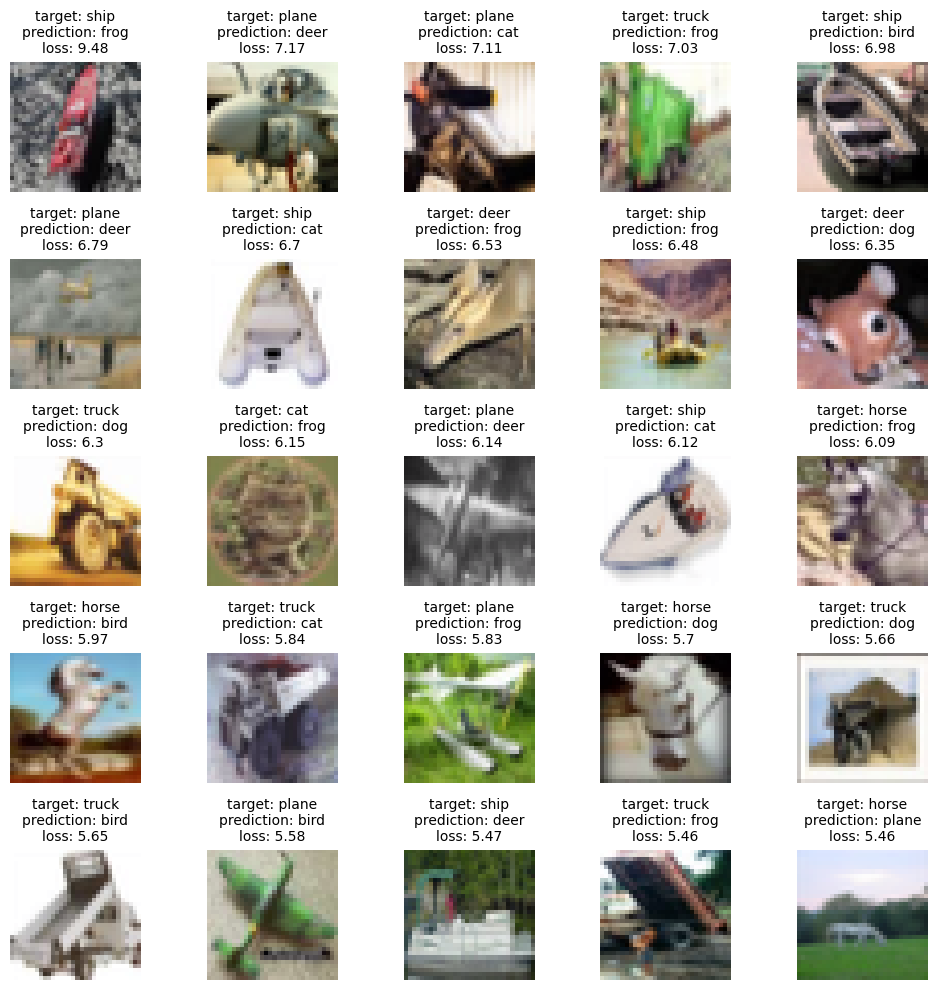

In [28]:
incr_groups_df = plot_top_loss(model, device, test_loader, criterion,
                               label_names = class_labels, img_rows=5, img_cols = 5)

In [29]:
incr_groups_df.loc[incr_groups_df.image > 1]

,target,prediction,loss,image
60,plane,bird,1.740930,240
20,cat,dog,1.341994,183
26,deer,bird,1.730752,148
36,dog,cat,1.383377,136
67,plane,ship,1.821780,130
...,...,...,...,...
35,dog,car,2.151851,3
58,horse,ship,2.786449,2
52,horse,car,2.726426,2
50,frog,ship,2.104373,2
